<div class="alert alert-block alert-info">
<b>Disclaimer:</b> This project is only for research purposes. It does not contain any financial advice. Invest on your own risk. 
</div>

## Table of content
* [Import libraries](#import)
* [Importing data](#import_data)
* [Data modification](#modify)
* [EDA(Exploratory data analysis)](#eda)
* [LSTM model(Long short-term memory)](#lstm)
    * [Train&Test data](#train_test1)
    * [Modelling](#modelling1)
* [Linear regression](#linear)
    * [Train&Test data](#train_test2)
    * [Modelling](#modelling2)

***

## Importing libraries <a class="anchor" id="import"></a>

In [1]:
# Importing the libraries that needed. If the library is not installed, can 
# run the code "!pip install keras" and just change keras to other library name
# to install the library. 
# !pip install keras

import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from pandas import Series
from math import sqrt
from keras import optimizers
from keras.callbacks import History
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


%matplotlib inline

# Set seed to initialize the random number generator
np.random.seed(10)

***

## Importing data <a class="anchor" id="import_data"></a>

In [2]:
# Set the date as the index
df = pd.read_csv('AAPL.csv',
                index_col=0,
                 parse_dates=True)

# Only taking historical prices from the past 10 years
df = df.loc['2013-3-1': '2023-2-28']

# Reverse it 
df = df[::-1]

***

## Data modification <a class="anchor" id="modify"></a>

In [3]:
# Understand the format of the data is correct
# Few of the colunmns are labelled as object where it suppose to be numerics
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2013-03-04 to 2023-02-28
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  2516 non-null   object
 1   Volume      2516 non-null   int64 
 2   Open        2516 non-null   object
 3   High        2516 non-null   object
 4   Low         2516 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.9+ KB


In [4]:
# Converting the data 
df['Close/Last'] = pd.to_numeric(df['Close/Last'].str.replace('$', ''))
df['Open'] = pd.to_numeric(df['Open'].str.replace('$', ''))
df['High'] = pd.to_numeric(df['High'].str.replace('$', ''))
df['Low'] = pd.to_numeric(df['Low'].str.replace('$', ''))

# Add in some common stock indicators 
df['RSI']=ta.rsi(df['Close/Last'], length=15)
df['EMAF']=ta.ema(df['Close/Last'], length=20)
df['EMAM']=ta.ema(df['Close/Last'], length=100)
df['EMAS']=ta.ema(df['Close/Last'], length=150)
df['Target']=df['Close/Last'].shift(-1)

# Drop the empty rows and the volume column
df.drop('Volume', axis=1, inplace=True)
df.dropna(inplace=True)

# Check the types after converting
df.dtypes

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_22656/1536079274.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close/Last'] = pd.to_numeric(df['Close/Last'].str.replace('$', ''))
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_22656/1536079274.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Open'] = pd.to_numeric(df['Open'].str.replace('$', ''))
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_22656/1536079274.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['High'] = pd.to_numeric(df['High'].str.replace('$

Close/Last    float64
Open          float64
High          float64
Low           float64
RSI           float64
EMAF          float64
EMAM          float64
EMAS          float64
Target        float64
dtype: object

In [5]:
df.head(20)

,Close/Last,Open,High,Low,RSI,EMAF,EMAM,EMAS,Target
Date,,,,,,,,,
2013-10-03,17.2646,17.5182,17.5839,17.1692,51.714599,17.195509,16.526686,15.987272,17.2511
2013-10-04,17.2511,17.2807,17.3071,17.0929,51.517534,17.200803,16.541031,16.004011,17.4196
2013-10-07,17.4196,17.3771,17.5946,17.3339,53.868380,17.221641,16.558428,16.022761,17.1764
2013-10-08,17.1764,17.4979,17.5229,17.1621,50.110885,17.217332,16.570665,16.038041,17.3781
2013-10-09,17.3781,17.3086,17.4211,17.0814,53.022664,17.232643,16.586654,16.055790,17.4871
2013-10-10,17.4871,17.5471,17.5850,17.3943,54.558310,17.256877,16.604484,16.074748,17.6004
2013-10-11,17.6004,17.3925,17.6371,17.3271,56.154534,17.289594,16.624206,16.094955,17.7157
2013-10-14,17.7157,17.4939,17.7707,17.4768,57.771884,17.330175,16.645819,16.116422,17.8100
2013-10-15,17.8100,17.7680,17.9286,17.6971,59.094124,17.375873,16.668872,16.138853,17.8969


In [6]:
# Basic understanding for the data
df.describe()

,Close/Last,Open,High,Low,RSI,EMAF,EMAM,EMAS,Target
count,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000
mean,67.422620,67.373748,68.144076,66.636706,55.446731,66.894882,64.730922,63.313071,67.477626
std,49.338553,49.297715,49.959213,48.660287,12.497875,49.044053,47.957957,47.104044,49.355155
min,17.176400,17.280700,17.307100,17.081400,22.304008,17.195509,16.526686,15.987272,17.176400
25%,28.533425,28.505000,28.849375,28.315625,46.348006,28.340299,27.907821,27.621345,28.544025
50%,43.750000,43.736250,43.965000,43.472500,55.662196,43.325848,44.035493,43.662638,43.751250
75%,117.232500,117.627500,119.120000,115.995000,64.284670,116.663273,105.810540,98.887157,117.335000
max,182.010000,182.630000,182.940000,179.120000,89.779292,174.825981,165.738864,162.090712,182.010000


***

## EDA (Exploratory data analysis) <a class="anchor" id="eda"></a>

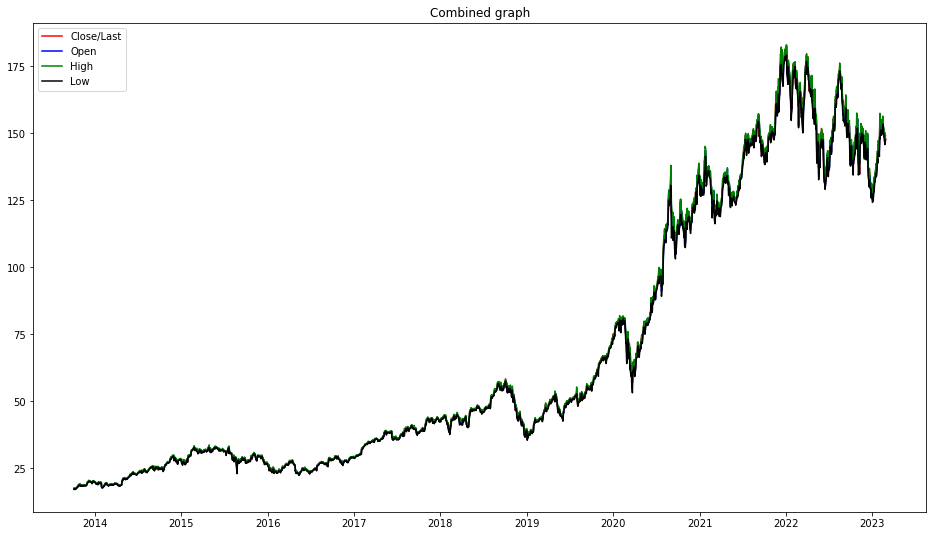

In [7]:
# Graph 1
# Combined graph of 4 variables of the past 10 years
fig, ax = plt.subplots(figsize=(16,9))
ax.plot('Close/Last', data=df, color='red', label='Close/Last')
ax.plot('Open', data=df, color='blue', label='Open')
ax.plot('High', data=df, color='green', label='High')
ax.plot('Low', data=df, color='black', label='Low')
ax.set_title('Combined graph')
ax.legend()

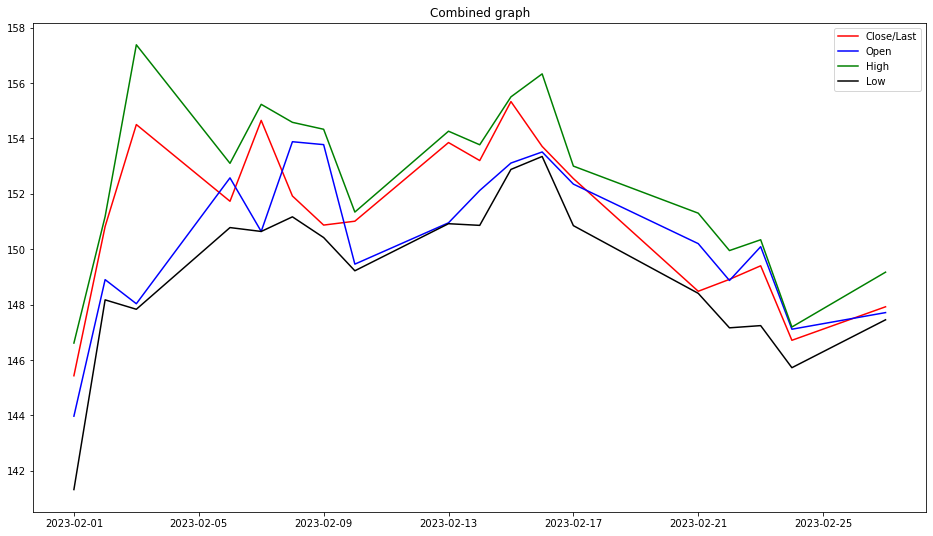

In [8]:
# Graph 2
# Combined graph of 4 variables for 1 month (Feb of 2023)
df1 = df.loc['2023-2-1': '2023-2-28']
fig, ax = plt.subplots(figsize=(16,9))
ax.plot('Close/Last', data=df1, color='red', label='Close/Last')
ax.plot('Open', data=df1, color='blue', label='Open')
ax.plot('High', data=df1, color='green', label='High')
ax.plot('Low', data=df1, color='black', label='Low')
ax.set_title('Combined graph')
ax.legend()

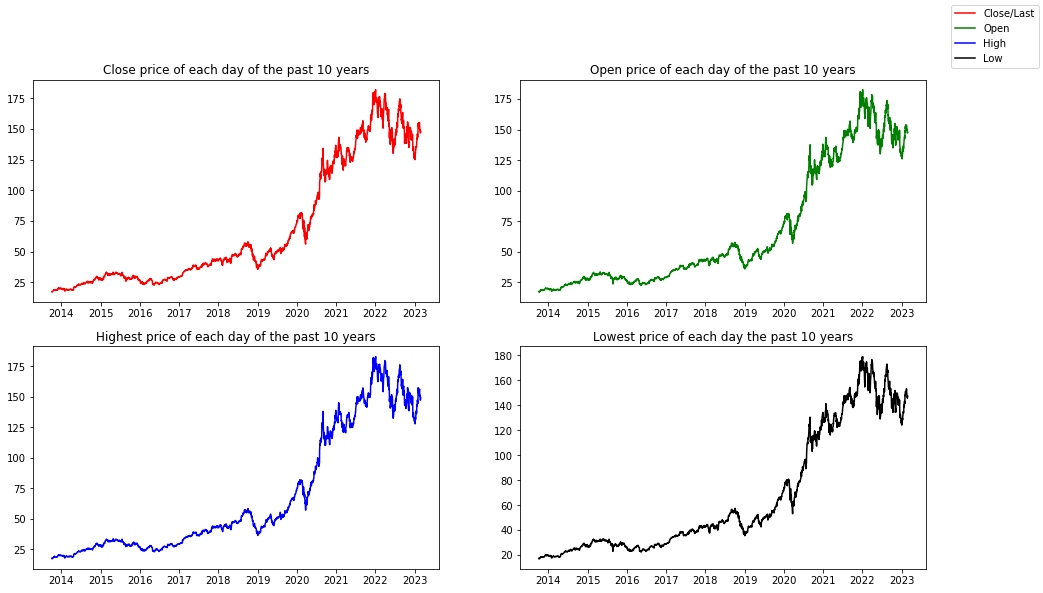

In [9]:
# Graph 3
# 4 graphs with each variables from the past 10 years
plot_objects = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
fig, ((ax1, ax2), (ax3, ax4)) = plot_objects
ax1.plot('Close/Last', data=df, c='red')
ax2.plot('Open', data=df, c='green')
ax3.plot('High', data=df, c='blue')
ax4.plot('Low', data=df, c='black')

ax1.set_title('Close price of each day of the past 10 years')
ax2.set_title('Open price of each day of the past 10 years')
ax3.set_title('Highest price of each day of the past 10 years')
ax4.set_title('Lowest price of each day the past 10 years')

fig.legend()

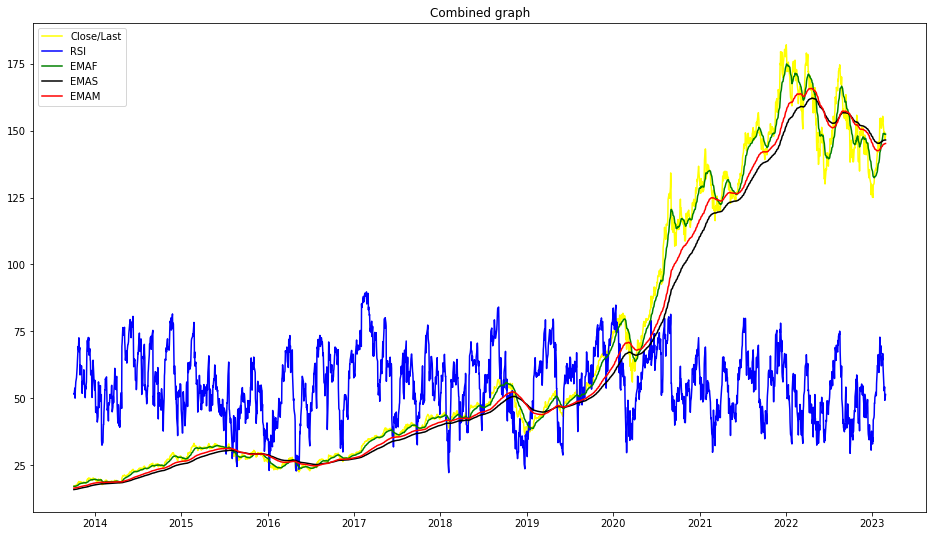

In [10]:
# Graph 4
# Combined graph of 5 independent variable (Close/last, RSI, EMAF, EMAM, EMAS) of the past 10 years
fig, ax = plt.subplots(figsize=(16,9))
ax.plot('Close/Last', data=df, color='yellow', label='Close/Last')
ax.plot('RSI', data=df, color='blue', label='RSI')
ax.plot('EMAF', data=df, color='green', label='EMAF')
ax.plot('EMAS', data=df, color='black', label='EMAS')
ax.plot('EMAM', data=df, color='red', label='EMAM')
ax.set_title('Combined graph')
ax.legend()

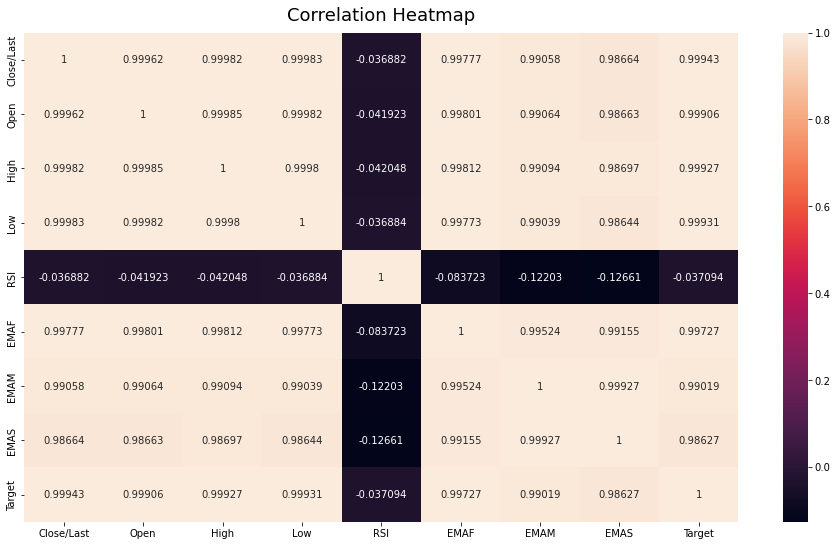

In [11]:
# Plot 5
# Heatmap correlation of variables from the past 10 years data (after scalling)

plt.figure(figsize=(16,9))
# True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(),annot=True, fmt='.5g')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

***

## LSTM model(Long short-term memory) <a class="anchor" id="lstm"></a>

### Train&Test data set <a class="anchor" id="train_test1"></a>

In [12]:
# Normalizing the data
df1=df
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(df1)
print(df_scaled)

[[5.35085080e-04 1.43635322e-03 1.67116557e-03 ... 0.00000000e+00
  0.00000000e+00 4.53184302e-04]
 [4.53184302e-04 0.00000000e+00 0.00000000e+00 ... 9.61371777e-05
  1.14572550e-04 1.47542734e-03]
 [1.47542734e-03 5.83008214e-04 1.73576626e-03 ... 2.12732320e-04
  2.42902980e-04 0.00000000e+00]
 ...
 [8.02164122e-01 8.03204489e-01 8.03179199e-01 ... 8.61558355e-01
  8.93017375e-01 7.85844634e-01]
 [7.85844634e-01 7.85182036e-01 7.84161238e-01 ... 8.61774449e-01
  8.93040022e-01 7.93185370e-01]
 [7.93185370e-01 7.88810718e-01 7.96115385e-01 ... 8.62146843e-01
  8.93172062e-01 7.90091341e-01]]


In [13]:
# Multiple feature from data provided to the model
X = []


# Creating a 30 days sliding windows
backcandles = 30
print(df_scaled.shape[0])
for j in range(8):#df_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, df_scaled.shape[0]):#backcandles+2
        X[j].append(df_scaled[i-backcandles:i, j])

# Move axis from 0 to position 2
# Reshaping the axis
X=np.moveaxis(X, [0], [2])

# Erase first elements of y because of backcandles to match X length
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(df_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))


print(X)
print(X.shape)
print(y)
print(y.shape)

2366
[[[5.35085080e-04 1.43635322e-03 1.67116557e-03 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [4.53184302e-04 0.00000000e+00 0.00000000e+00 ... 3.35875314e-05
   9.61371777e-05 1.14572550e-04]
  [1.47542734e-03 5.83008214e-04 1.73576626e-03 ... 1.65781560e-04
   2.12732320e-04 2.42902980e-04]
  ...
  [8.25681172e-03 7.80408505e-03 7.99358099e-03 ... 7.74011237e-03
   4.99754246e-03 4.76852845e-03]
  [8.46550703e-03 7.30272218e-03 8.47838805e-03 ... 7.83449455e-03
   5.16998878e-03 4.93966997e-03]
  [8.60079498e-03 7.37408625e-03 8.11855616e-03 ... 7.93336129e-03
   5.34197976e-03 5.11056633e-03]]

 [[4.53184302e-04 0.00000000e+00 0.00000000e+00 ... 3.35875314e-05
   9.61371777e-05 1.14572550e-04]
  [1.47542734e-03 5.83008214e-04 1.73576626e-03 ... 1.65781560e-04
   2.12732320e-04 2.42902980e-04]
  [0.00000000e+00 1.31358282e-03 1.30288125e-03 ... 1.38447691e-04
   2.94743524e-04 3.47486330e-04]
  ...
  [8.46550703e-03 7.30272218e-03 8.47838805e-03 ... 7.83449455e-03
   5.

In [14]:
# Split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

1868
(1868, 30, 8)
(468, 30, 8)
(1868, 1)
(468, 1)


### Data Modelling <a class="anchor" id="modelling1"></a>

In [15]:
# Building the model and putting parameters for each layer
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

# Stating the optimizer and the evaluation metrics for optimizing
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

# Fit in the data and set the iterations for 30 times
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
113/113 [==============================] - 4s 22ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 2/30
113/113 [==============================] - 2s 19ms/step - loss: 8.3468e-05 - val_loss: 0.0010
Epoch 3/30
113/113 [==============================] - 2s 18ms/step - loss: 6.8532e-05 - val_loss: 0.0011
Epoch 4/30
113/113 [==============================] - 2s 18ms/step - loss: 6.6716e-05 - val_loss: 8.6898e-04
Epoch 5/30
113/113 [==============================] - 2s 18ms/step - loss: 6.5121e-05 - val_loss: 8.3908e-04
Epoch 6/30
113/113 [==============================] - 2s 19ms/step - loss: 6.5893e-05 - val_loss: 8.6135e-04
Epoch 7/30
113/113 [==============================] - 2s 18ms/step - loss: 6.6805e-05 - val_loss: 9.1395e-04
Epoch 8/30
113/113 [==============================] - 2s 18ms/step - loss: 7.4525e-05 - val_loss: 7.6257e-04
Epoch 9/30
113/113 [==============================] - 2s 18ms/step - loss: 6.1800e-05 - val_loss: 7.5918e-04
Epoch 10/30
113/113 [==============

In [16]:
# Predict the test dataset
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 1s 12ms/step
[0.74694425] [0.70570321]
[0.7423076] [0.69623912]
[0.7399779] [0.71067792]
[0.7337474] [0.71310461]
[0.7387581] [0.71110259]
[0.7433721] [0.70618854]
[0.7444638] [0.70558187]
[0.7408762] [0.69332709]
[0.7416045] [0.69987915]
[0.7291351] [0.67142621]


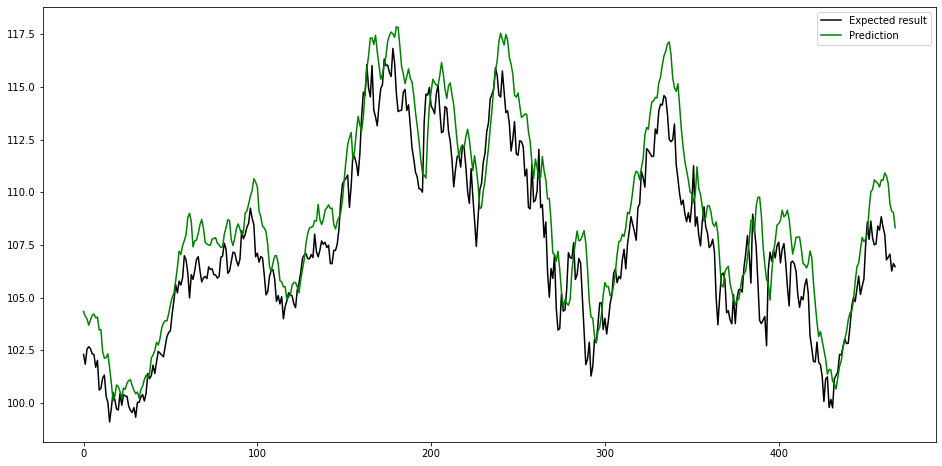

In [17]:
# Reverse scalling 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
n = df1['Target']
n = n.values.reshape(-1,1)
scaler.fit(n)
scaled = scaler.transform(n)


# For inverse transformation (Prediction)
inversed_pred = scaler.inverse_transform(y_pred)


# For inverse transformation (Test)
inversed_test = scaler.inverse_transform(y_test)

# Plotting the predcited and the actual value
plt.figure(figsize=(16,8))
plt.plot(inversed_test, color = 'black', label = 'Expected result')
plt.plot(inversed_pred, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [18]:
# Evaluation Metrics

# MAE
mae_LSTM = mean_absolute_error(inversed_test, inversed_pred)
print('MAE: %f' % mae_LSTM)

# RSME
mse_LSTM = mean_squared_error(inversed_test, inversed_pred)
rmse_LSTM = sqrt(mse_LSTM)
print(f'RSME: {rmse_LSTM}')

MAE: 1.596608
RSME: 1.9522168464072205


***

## Linear regression <a class="anchor" id="linear"></a>

## Train&Test data set <a class="anchor" id="train_test2"></a>

In [19]:
def create_train_test_data(df):
    
    # Seperating the target and predictors
    features= df.drop(columns=['Target'], axis=1)
    target = df['Target']
    
    df_len = df.shape[0]
    print('Total length of the data : ', str(df_len))
    
    # Creating the split
    train_df = int(df_len*0.88)
    print('Length of the training dataset: ', str(train_df))
    
    val_df = train_df+ int(df_len * 0.1)
    print('Validation Set length - ', str(int(df_len * 0.1)))

    print('Test Set length - ', str(int(df_len * 0.02)))

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_df], features[train_df:val_df], features[val_df:]
    Y_train, Y_val, Y_test = target[:train_df], target[train_df:val_df], target[val_df:]

    # Print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [20]:
# Check the shape of each dataset 
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_data(df)

Total length of the data :  2366
Length of the training dataset:  2082
Validation Set length -  236
Test Set length -  47
(2082, 8) (236, 8) (48, 8)
(2082,) (236,) (48,)


### Data Modelling <a class="anchor" id="modelling2"></a>

In [21]:
# Fitting the model 
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

# Predict the value
Y_train_pred = model_lr.predict(X_train)
Y_val_pred = model_lr.predict(X_val)
Y_test_pred = model_lr.predict(X_test)

In [22]:
# Evaluation metrics
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

Validation RMSE:  3.49
Validation MAE:  2.76


In [23]:
# Rehaspe the predicted value
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')

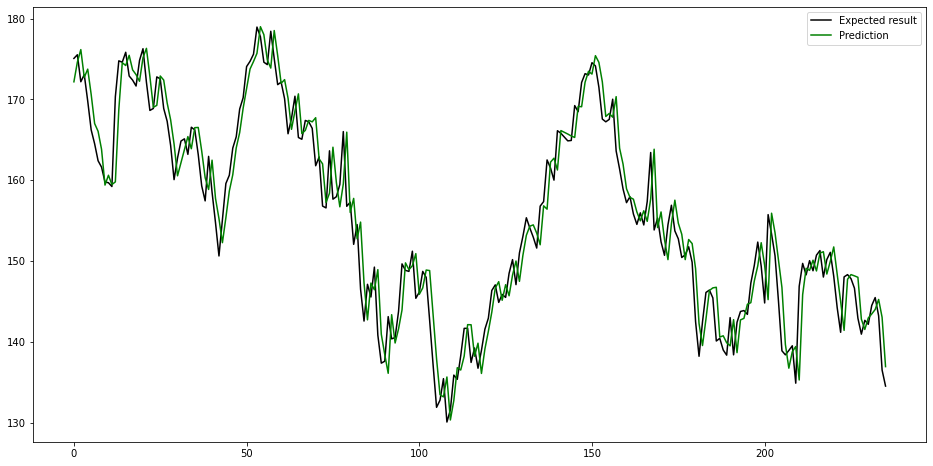

In [24]:
# Predicted value and the actual value
plt.figure(figsize=(16,8))
plt.plot(df_pred['Actual'], color = 'black', label = 'Expected result')
plt.plot(df_pred['Predicted'], color = 'green', label = 'Prediction')
plt.legend()
plt.show()